# Mother Nature 🌳

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

city_daily_temperature_df = pd.read_csv("Datasets/city-daily-temperature.csv")
global_land_temperature_df = pd.read_csv("Datasets/global_land_temperatures_by_country.csv")
global_country_info_df = pd.read_csv("Datasets/global-country-information.csv")

/var/folders/5h/dtcrckm92731w9ydx7f5rfvw0000gn/T/ipykernel_50395/1087545288.py:9: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  city_daily_temperature_df = pd.read_csv("Datasets/city-daily-temperature.csv")


### City Daily Temperature Dataset

In [114]:
# Preprocessing City Daily Temperature
city_daily_temperature_df.drop(['State'], axis = 1, inplace = True)
# We are considering temperatures for years between 2000 and 2019 since 2020 was an outlier year for temperatures
city_daily_temperature_df = city_daily_temperature_df[city_daily_temperature_df['Year'].between(2000, 2019)]

# Filtering invlaid temperatures
city_daily_temperature_df = city_daily_temperature_df[city_daily_temperature_df['AvgTemperature'] <= 134]
city_daily_temperature_df = city_daily_temperature_df[city_daily_temperature_df['AvgTemperature'] != -99]

# Renaming countries
country_remappings = {
    'Congo': 'Democratic Republic of the Congo', 
    'US': 'United States',
    'The Netherlands' : 'Netherlands',
    'Equador' : 'Ecuador',
    'Myanmar (Burma)' : 'Myanmar',
    'Serbia-Montenegro' : 'Montenegro'
}
city_daily_temperature_df['Country'] = city_daily_temperature_df['Country'].replace(country_remappings)

# Grouping data 
avg_temp_per_year = city_daily_temperature_df.groupby('Year')['AvgTemperature'].mean().reset_index()
avg_temp_per_region_per_year = city_daily_temperature_df.groupby(['Region', 'Year'])['AvgTemperature'].mean().reset_index()
avg_temp_per_country_per_year = city_daily_temperature_df.groupby(['Country', 'Year'])['AvgTemperature'].mean().reset_index()
avg_temp_per_country_per_month = city_daily_temperature_df.groupby(['Country', 'Month'])['AvgTemperature'].mean().reset_index()

print(f"Unique countries: {city_daily_temperature_df['Country'].unique()}")
city_daily_temperature_df

Unique countries: ['Algeria' 'Burundi' 'Benin' 'Central African Republic'
 'Democratic Republic of the Congo' 'Egypt' 'Ethiopia' 'Gabon' 'Gambia'
 'Guinea' 'Guinea-Bissau' 'Ivory Coast' 'Kenya' 'Morocco' 'Madagascar'
 'Mauritania' 'Malawi' 'Mozambique' 'Namibia' 'Nigeria' 'Senegal'
 'Sierra Leone' 'South Africa' 'Togo' 'Tunisia' 'Tanzania' 'Uganda'
 'Zambia' 'Bangladesh' 'China' 'Hong Kong' 'India' 'Indonesia' 'Japan'
 'Kazakhstan' 'Kyrgyzstan' 'Laos' 'Malaysia' 'Mongolia' 'Myanmar' 'Nepal'
 'North Korea' 'Pakistan' 'Philippines' 'Singapore' 'South Korea'
 'Sri Lanka' 'Taiwan' 'Tajikistan' 'Thailand' 'Turkmenistan' 'Uzbekistan'
 'Vietnam' 'Australia' 'New Zealand' 'Albania' 'Austria' 'Belarus'
 'Belgium' 'Bulgaria' 'Croatia' 'Cyprus' 'Czech Republic' 'Denmark'
 'Finland' 'France' 'Germany' 'Georgia' 'Greece' 'Hungary' 'Iceland'
 'Ireland' 'Italy' 'Latvia' 'Macedonia' 'Netherlands' 'Norway' 'Poland'
 'Portugal' 'Romania' 'Russia' 'Montenegro' 'Slovakia' 'Spain' 'Sweden'
 'Switzerland' '

,Region,Country,City,Month,Day,Year,AvgTemperature
1826,Africa,Algeria,Algiers,1,1,2000,43.9
1827,Africa,Algeria,Algiers,1,2,2000,46.5
1828,Africa,Algeria,Algiers,1,3,2000,46.1
1829,Africa,Algeria,Algiers,1,4,2000,45.7
1830,Africa,Algeria,Algiers,1,5,2000,46.2
...,...,...,...,...,...,...,...
2906322,North America,United States,San Juan Puerto Rico,7,27,2013,82.4
2906323,North America,United States,San Juan Puerto Rico,7,28,2013,81.6
2906324,North America,United States,San Juan Puerto Rico,7,29,2013,84.2
2906325,North America,United States,San Juan Puerto Rico,7,30,2013,83.8


### Global Land Temperature Dataset

In [115]:
# Preprocessing City Daily Temperature
global_land_temperature_df.dropna(inplace=True)

# Converting Temperatures from Celcius to Fahrenheit
global_land_temperature_df['AverageTemperature'] = global_land_temperature_df['AverageTemperature'] * 9/5 + 32

# Remapping Countries
country_remappings = {
    'Antigua And Barbuda': 'Antigua and Barbuda', 
    'Bosnia And Herzegovina': 'Bosnia and Herzegovina',
    'Ireland': 'Republic of Ireland',
    'Congo (Democratic Republic Of The)': 'Democratic Republic of the Congo',
    'Federated States Of Micronesia': 'Federated States of Micronesia',
    'Guinea Bissau': 'Guinea-Bissau',
    'Macedonia': 'North Macedonia',
    'Saint Kitts And Nevis': 'Saint Kitts and Nevis',
    'Saint Vincent And The Grenadines': 'Saint Vincent and the Grenadines',
    'Sao Tome And Principe': 'São Tomé and Príncipe',
    'Bahamas': 'The Bahamas',
    'Gambia': 'The Gambia',
    'Trinidad And Tobago': 'Trinidad and Tobago',
    'Timor Leste': 'East Timor',
    'Congo': 'Republic of the Congo'
}
global_land_temperature_df['Country'] = global_land_temperature_df['Country'].replace(country_remappings)
global_land_temperature_df["Country"].unique()

# Removing data for years before 1890
global_land_temperature_df.rename(columns={'dt': 'Date'}, inplace=True)
global_land_temperature_df["Date"] = pd.to_datetime(global_land_temperature_df["Date"])
start_date = pd.to_datetime('1890-01-01')
global_land_temperature_df = global_land_temperature_df[global_land_temperature_df["Date"] >= start_date]

global_land_temperature_df.isna().sum() / global_land_temperature_df.count()
global_land_temperature_df.index = range(1, len(global_land_temperature_df) + 1)

avg_global_land_temp_per_country = global_land_temperature_df.groupby(['Country', global_land_temperature_df['Date'].dt.year])['AverageTemperature'].mean()

global_land_temperature_df

,Date,AverageTemperature,AverageTemperatureUncertainty,Country
1,1890-01-01,33.9674,0.873,Åland
2,1890-02-01,29.5358,1.056,Åland
3,1890-03-01,32.5382,1.056,Åland
4,1890-04-01,36.9788,0.792,Åland
5,1890-05-01,47.9660,0.860,Åland
...,...,...,...,...
357182,2013-04-01,70.0556,0.495,Zimbabwe
357183,2013-05-01,66.3062,1.022,Zimbabwe
357184,2013-06-01,63.7034,0.473,Zimbabwe
357185,2013-07-01,62.6000,0.453,Zimbabwe


### Global Country Information Dataset

In [116]:
# Preprocessing Global Country Information
# pd.set_option('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None)
pd.options.mode.chained_assignment = None

#---------------------DROPPING UNNECESSARY COLUMNS---------------------
global_country_info_df.drop(['Fertility Rate','Population: Labor force participation (%)','Maternal mortality ratio','Unemployment rate','Gross tertiary education enrollment (%)','Gross primary education enrollment (%)','Density\n(P/Km2)','CPI','Abbreviation','Gasoline Price','Armed Forces size','CPI Change (%)','Latitude','Longitude','Tax revenue (%)','Calling Code','Currency-Code','Official language','Total tax rate', 'Physicians per thousand', 'Minimum wage', 'Out of pocket health expenditure',], axis = 1, inplace = True)

#---------------------FIXING COUNTIRES NAME ISSUES---------------------
global_country_info_df.loc[150, ['Country', 'Largest city', 'Capital/Major City']] = ['São Tomé and Príncipe', 'São Tomé', 'São Tomé']
global_country_info_df.loc[176, ['Capital/Major City', 'Largest city']] = ['Nuku\'alofa', 'Nuku\'alofa']
global_country_info_df.loc[181, 'Largest city'] = 'Funafuti'
global_country_info_df.loc[156, ['Capital/Major City', 'Largest city']] = ['Singapore', 'Singapore']
global_country_info_df.loc[97, ['Capital/Major City', 'Largest city']] = ['Tripoli', 'Tripoli']
global_country_info_df.loc[24, 'Largest city'] = 'Bandar Seri Begawan'
global_country_info_df.loc[120, 'Largest city'] = 'Denigomodu'
global_country_info_df.loc[175, ['Capital/Major City', 'Largest city']] = ['Lomé', 'Lomé']
global_country_info_df.loc[37, ['Capital/Major City', 'Largest city']] = ['Bogotá', 'Bogotá']
global_country_info_df.loc[40, ['Capital/Major City', 'Largest city']] = ['San José', 'San José']
global_country_info_df.loc[76, ['Capital/Major City', 'Largest city']] = ['Reykjavík', 'Reykjavík']
global_country_info_df.loc[104, ['Capital/Major City', 'Largest city']] = ['Malé', 'Malé']
global_country_info_df.loc[112, ['Capital/Major City', 'Largest city']] = ['Chișinău', 'Chișinău']
global_country_info_df.loc[23, ['Capital/Major City', 'Largest city']] = ['Brasília', 'São Paulo']
global_country_info_df.loc[31, ['Capital/Major City']] = ['Yaoundé']
global_country_info_df.loc[136, ['Capital/Major City']] = ['Asunción']
global_country_info_df.loc[43, ['Largest city']] = ['Nicosia']
global_country_info_df.loc[168, ['Largest city']] = ['Stockholm']
global_country_info_df.loc[169, ['Largest city']] = ['Zurich']
global_country_info_df.drop([133, 73], inplace=True) # Getting rid of countrys where majority/all of the data is missing

global_country_info_df['Population'] = global_country_info_df['Population'].str.replace(',', '', regex=False).astype(int)
global_country_info_df['GDP'] = global_country_info_df['GDP'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(int)
global_country_info_df['Agricultural Land( %)'] = pd.to_numeric(global_country_info_df['Agricultural Land( %)'].str.replace('%', ''), errors='coerce')
global_country_info_df['Forested Area (%)'] = pd.to_numeric(global_country_info_df['Forested Area (%)'].str.replace('%', ''), errors='coerce')

#---------------------FIXING MISSING CO2-EMMISIONS IN DATAFRAME---------------------
def replace_missing_co2(df):
    for index, row in df[df['Co2-Emissions'].isna()].iterrows():
        closest_country = df.loc[df['Co2-Emissions'].notna(), :] 
        population_diff = abs(closest_country['Population'] - row['Population'])
        gdp_diff = abs(closest_country['GDP'] - row['GDP']) 
        combined_diff = population_diff + gdp_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        df.at[index, 'Co2-Emissions'] = closest_row['Co2-Emissions']    
    return df

#---------------------FIXING MISSING BIRTH RATES IN DATAFRAME---------------------
def replace_missing_birth_rate(df):
    for index, row in df[df['Birth Rate'].isna()].iterrows():
        closest_country = df.loc[df['Birth Rate'].notna(), :] 
        population_diff = abs(closest_country['Population'] - row['Population'])
        gdp_diff = abs(closest_country['GDP'] - row['GDP'])  # GDP is now a float
        combined_diff = population_diff + gdp_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        df.at[index, 'Birth Rate'] = closest_row['Birth Rate']    
    return df

#---------------------FIXING MISSING URBAN POPULATION IN DATAFRAME---------------------
def replace_missing_urban(df):
    df['Urban_population'] = pd.to_numeric(df['Urban_population'].str.replace(',', ''), errors='coerce')
    for index, row in df[df['Urban_population'].isna()].iterrows():
        closest_country = df.loc[(df['Urban_population'].notna()) &  (df['Urban_population'] < df['Population']) & (df['Population'].notna()) ] 
        if closest_country.empty:
            continue  
        population_diff = closest_country['Population'] - row['Population']
        gdp_diff = closest_country['GDP'] - row['GDP'] 
        combined_diff = population_diff + gdp_diff
        sorted_indices = combined_diff.sort_values().index
        for idx in sorted_indices:
            closest_row = closest_country.loc[idx]
            if closest_row['Urban_population'] < row['Population']:
                df.at[index, 'Urban_population'] = closest_row['Urban_population']
                break
    return df

#---------------------FIXING MISSING LIFE EXPECTANCY IN DATAFRAME---------------------
def replace_missing_life_expectancy(df):
    for index, row in df[df['Life expectancy'].isna()].iterrows():
        closest_country = df.loc[df['Life expectancy'].notna(), :] 
        population_diff = abs(closest_country['Population'] - row['Population'])
        gdp_diff = abs(closest_country['GDP'] - row['GDP'])  
        combined_diff = population_diff + gdp_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        df.at[index, 'Life expectancy'] = closest_row['Life expectancy']    
    return df

#---------------------FIXING MISSING INFANT MORTALITY IN DATAFRAME---------------------
def replace_missing_infant_mortality(df):
    for index, row in df[df['Infant mortality'].isna()].iterrows():
        closest_country = df.loc[df['Infant mortality'].notna(), :] 
        population_diff = abs(closest_country['Population'] - row['Population'])
        gdp_diff = abs(closest_country['GDP'] - row['GDP'])  
        combined_diff = population_diff + gdp_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        df.at[index, 'Infant mortality'] = closest_row['Infant mortality']    
    return df

#---------------------FIXING MISSING INFANT MORTALITY IN DATAFRAME---------------------
def replace_missing_land(df):
    for index, row in df[df['Agricultural Land( %)'].isna()].iterrows():
        closest_country = df.loc[df['Agricultural Land( %)'].notna(), :] 
        population_diff = abs(closest_country['Population'] - row['Population'])
        gdp_diff = abs(closest_country['GDP'] - row['GDP']) 
        combined_diff = population_diff + gdp_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        df.at[index, 'Agricultural Land( %)'] = closest_row['Agricultural Land( %)']
        df.at[index, 'Forested Area (%)'] = closest_row['Forested Area (%)']         
    return df

#---------------------FIXING PERCENTAGES IN DATAFRAME---------------------
def correct_land_percentages(global_country_info_df):
    rows_to_replace = global_country_info_df[(global_country_info_df['Agricultural Land( %)'] + global_country_info_df['Forested Area (%)']) > 100]
    for index, row in rows_to_replace.iterrows():
        closest_country = global_country_info_df.loc[(global_country_info_df['Agricultural Land( %)'].notna()) & (global_country_info_df['Forested Area (%)'].notna()) & (global_country_info_df.index != index) & ((global_country_info_df['Agricultural Land( %)'] + global_country_info_df['Forested Area (%)']) <= 100)]
        population_diff = abs(closest_country['Population'] - row['Population'])
        land_diff = abs((closest_country['Agricultural Land( %)'] + closest_country['Forested Area (%)']) - 100)
        combined_diff = population_diff + land_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        global_country_info_df.at[index, 'Agricultural Land( %)'] = closest_row['Agricultural Land( %)']
        global_country_info_df.at[index, 'Forested Area (%)'] = closest_row['Forested Area (%)']
    return global_country_info_df

global_country_info_df = replace_missing_co2(global_country_info_df)
global_country_info_df = replace_missing_birth_rate(global_country_info_df)
global_country_info_df = replace_missing_urban(global_country_info_df)
global_country_info_df = replace_missing_life_expectancy(global_country_info_df)
global_country_info_df = replace_missing_infant_mortality(global_country_info_df)
global_country_info_df = replace_missing_land(global_country_info_df)
global_country_info_df = correct_land_percentages(global_country_info_df)
global_country_info_df['Land Area(Km2)'] = global_country_info_df['Land Area(Km2)'].str.replace(',', '', regex=False).astype(int)
global_country_info_df['Co2-Emissions'] = global_country_info_df['Co2-Emissions'].str.replace(',', '', regex=False).astype(int)
global_country_info_df['Urban_population'] = global_country_info_df["Urban_population"].astype(int)
global_country_info_df = global_country_info_df.sort_values(by='Co2-Emissions', ascending=False)
global_country_info_df = global_country_info_df[['Country','Capital/Major City','Largest city','Population','Urban_population','GDP','Land Area(Km2)','Agricultural Land( %)','Forested Area (%)','Birth Rate','Infant mortality','Life expectancy','Co2-Emissions']]
global_country_info_df = global_country_info_df.reset_index(drop=True)
global_country_info_df.index = range(1, len(global_country_info_df) + 1)
global_country_info_df

,Country,Capital/Major City,Largest city,Population,Urban_population,GDP,Land Area(Km2),Agricultural Land( %),Forested Area (%),Birth Rate,Infant mortality,Life expectancy,Co2-Emissions
1,China,Beijing,Shanghai,1397715000,842933962,19910000000000,9596960,56.2,22.4,10.90,7.4,77.0,9893038
2,United States,"Washington, D.C.",New York City,328239523,270663028,21427700000000,9833517,44.4,33.9,11.60,5.6,78.5,5006302
3,India,New Delhi,Kurebhar,1366417754,471031528,2611000000000,3287263,60.4,23.8,17.86,29.9,69.4,2407672
4,Russia,Moscow,Moscow,144373535,107683889,1699876578871,17098240,13.3,49.8,11.50,6.1,72.7,1732027
5,Japan,Tokyo,Tokyo,126226568,115782416,5081769542380,377944,12.3,68.5,7.40,1.8,84.2,1135886
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,São Tomé and Príncipe,São Tomé,São Tomé,215056,158277,429016605,964,12.4,60.4,31.54,24.4,70.2,121
190,Kiribati,South Tarawa,South Tarawa,117606,64489,194647202,811,42.0,15.0,27.89,41.2,68.1,66
191,Nauru,Yaren District,Denigomodu,10084,7362,133000000,21,42.0,15.0,27.89,41.2,68.1,66
192,Liechtenstein,Vaduz,Schaan,38019,5464,6552858739,160,32.2,43.1,9.90,2.6,83.0,51


In [117]:
# Combining the yearly average temperatures by country with the global country information
combined_yearly_df = pd.merge(global_country_info_df, global_land_temperature_df, on='Country')
combined_yearly_df['Date'] = pd.to_datetime(combined_yearly_df['Date'])
combined_yearly_df.groupby(["Population", "Country"], group_keys=False)["AverageTemperature"].mean()


Population  Country              
18233       Palau                    81.067341
33860       San Marino               57.302931
38019       Liechtenstein            40.794138
38964       Monaco                   48.675029
52823       Saint Kitts and Nevis    78.812658
                                       ...    
216565318   Pakistan                 69.375105
270203917   Indonesia                78.455124
328239523   United States            48.023777
1366417754  India                    75.425876
1397715000  China                    44.277703
Name: AverageTemperature, Length: 183, dtype: float64

In [118]:
# Combining the monthly average temperatures with the global country information
month_dict = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}
combined_monthly_df = pd.merge(global_country_info_df, avg_temp_per_country_per_month, on='Country')
combined_monthly_df['Month'] = combined_monthly_df['Month'].replace(month_dict)

### ANOVA Test

p-value: 0.0031386639347898357


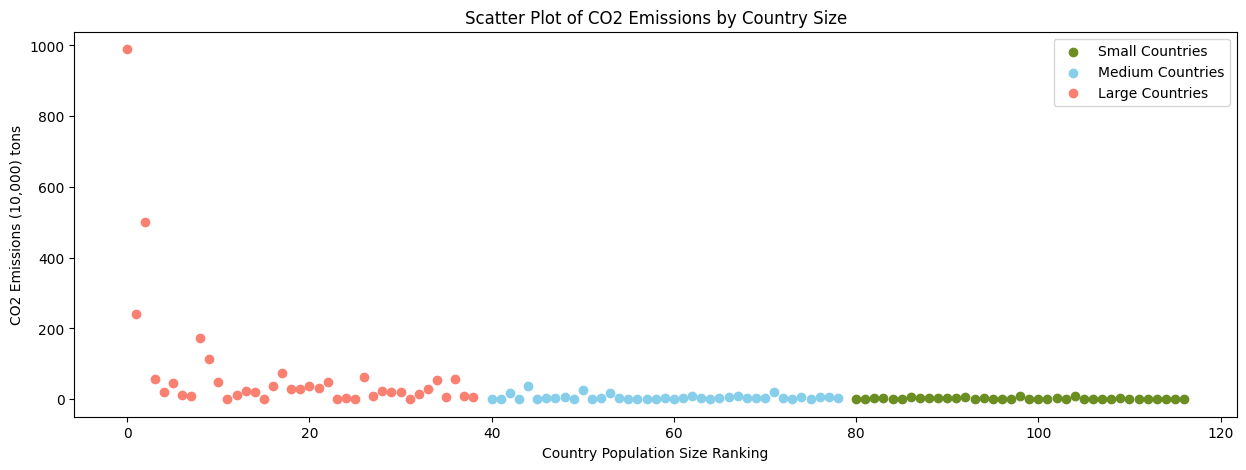

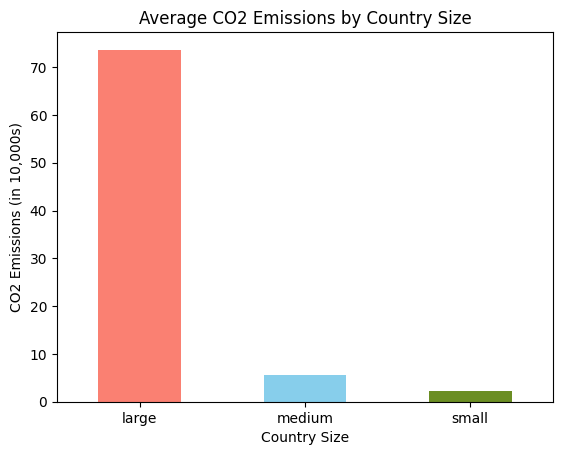

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
 large medium -68.0119 0.0106 -122.6734 -13.3505   True
 large  small -71.4524 0.0077 -126.8476 -16.0572   True
medium  small  -3.4404 0.9881  -58.8356  51.9547  False
-------------------------------------------------------


In [119]:
# ANOVA: Country size (small, medium, and large) vs Co2 emissions
first_inst_df = combined_monthly_df.drop_duplicates(subset='Country', keep='first').sort_values(by='Population', ascending=False).reset_index(drop=True)
first_inst_df['Co2-Emissions'] = first_inst_df['Co2-Emissions']/10000
large_df, medium_df, small_df = first_inst_df[0:39], first_inst_df[40:79], first_inst_df[80:]
small_df['Country Size'], medium_df['Country Size'], large_df['Country Size'] = 'small', 'medium', 'large'
df_combined = pd.concat([small_df, medium_df, large_df], ignore_index=True)

f_stat, p_val = stats.f_oneway(large_df['Co2-Emissions'], medium_df['Co2-Emissions'], small_df['Co2-Emissions']) #drop the null hypothesis (0.003)
print("p-value:", float(p_val))

# plot scatterplot
plt.figure(figsize=(15,5))
plt.scatter(small_df.index, small_df['Co2-Emissions'], color='olivedrab', label='Small Countries')
plt.scatter(medium_df.index, medium_df['Co2-Emissions'], color='skyblue', label='Medium Countries')
plt.scatter(large_df.index, large_df['Co2-Emissions'], color='salmon', label='Large Countries')
plt.xlabel('Country Population Size Ranking')
plt.ylabel('CO2 Emissions (10,000) tons')
plt.title('Scatter Plot of CO2 Emissions by Country Size')
plt.legend()
plt.show()

# plot bargraph
df_combined.groupby('Country Size')['Co2-Emissions'].mean().plot(kind='bar', color=['salmon', 'skyblue', 'olivedrab'])
plt.title('Average CO2 Emissions by Country Size')
plt.xlabel('Country Size')
plt.ylabel('CO2 Emissions (in 10,000s)')
plt.xticks(rotation=0)
plt.show()

# post-hoc
tukey = pairwise_tukeyhsd(endog=df_combined['Co2-Emissions'], groups=df_combined['Country Size'], alpha=0.05)
print(tukey)

    ANOVA Test Conclusion
> I used the ANOVA test to examine whether CO2 emissions differ significantly based on country size by population. The null hypothesis in this case is that country size does not affect CO2 emissions. The alternative hypothesis is that the size of a country affects the amount of CO2 emissions it produces. I divided the countries into small, medium, and large categories, with a third of the total countries in each category. From this, I obtained a **p-value of 0.003**, which is below the significance threshold of 0.05. This indicates a statistically significant difference in CO2 emissions across the three country size categories, so **we reject the null hypothesis**.
    
> I then conducted a post-hoc analysis using Tukey's HSD to determine which specific country size groups differ in terms of their emissions. This test showed that the adjusted p-value between large and medium countries was 0.0106, between large and small countries it was 0.0077, and for medium and small countries it was 0.9881. Since 0.0106 and 0.0077 are less than our significance threshold, these categories are statistically significant. From this, we can gather that **large countries have significantly higher emissions** compared to medium and small countries. We can also conclude that CO2 emissions are similar for small and medium countries.
***

### Chi-Square Test

p-value: 0.0


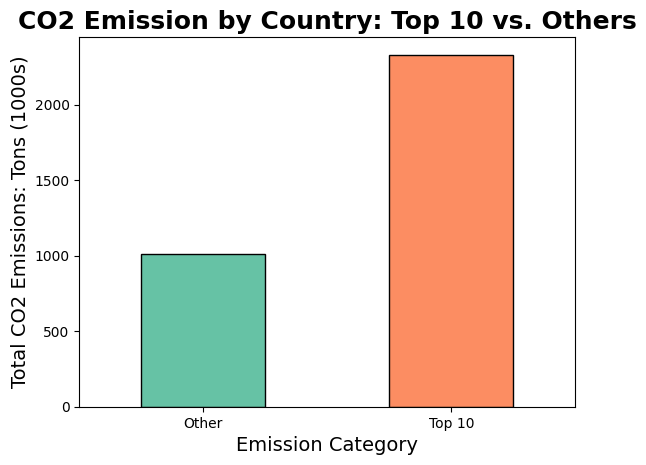

In [120]:
# Chi-Square: Top 10 countries by emission countries compare vs remaining countries
top_10 = global_country_info_df.sort_values(by='Co2-Emissions', ascending=False).head(10)
top_10_list = top_10['Country'].tolist()
global_country_info_df['EmissionCategory'] = global_country_info_df['Country'].apply(lambda x: 'Top 10' if x in top_10_list else 'Other')
merged_df = city_daily_temperature_df.merge(global_country_info_df[['Country', 'EmissionCategory']], on='Country', how='left')

merged_df['TempCategory'] = pd.cut(merged_df['AvgTemperature'], bins=[-np.inf, 10, 25, np.inf], labels=['Low', 'Medium', 'High'])
contingency_table = pd.crosstab(merged_df['TempCategory'], merged_df['EmissionCategory'])

# Chi Square Test Result Statistic
from scipy.stats import chi2_contingency
chi2, p, dof,expected = chi2_contingency(contingency_table)
print(f'p-value: {p}')

# Bar Plot comparing CO2 Emissions
emissions_sums = global_country_info_df.groupby('EmissionCategory')['Co2-Emissions'].sum()/10000
emissions_sums.plot(kind='bar', color=['#66c2a5', '#fc8d62'], edgecolor='black')

plt.title('CO2 Emission by Country: Top 10 vs. Others', fontsize=18, weight='bold')
plt.xlabel('Emission Category', fontsize=14)
plt.ylabel('Total CO2 Emissions: Tons (1000s)', fontsize=14)
plt.xticks(rotation=0)
plt.show()

    Summary of Chi-Square
    
Summary: Our null hypothesis is that the size of a country does not directly influence its Co2 emissions. Our alternate hypothesis is that the size of a country does directly influence its CO2 emissions. From our Chi-Square Analysis we can see a p-value of 0. Because of these results, we can safely assume to reject our null hypothesis and assume that there is a directy influence between our two variables, the top 10 countries and the remaining countries, with their CO2 emissions. Also, the top 10 countries make over double the Co2 emissions that the rest of the world combined does. From these findings, we can see that the top 10 countries greatly contribute to Co2 emissions, compared to the rest of the world.
***

### T-Test

p value = 0.13285391985389802


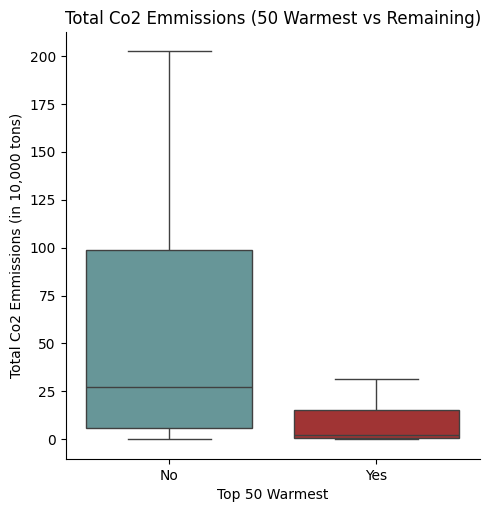

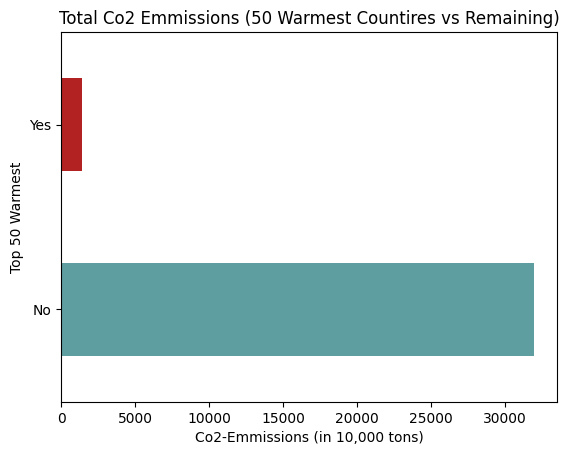

In [121]:
# T-Test: Comparing Co2-Emissions between Top 25 countries by average temperature and remaining countires
country_emissions_avgtemp_df = combined_yearly_df.groupby(['Co2-Emissions', 'Country'], as_index=False)['AverageTemperature'].mean()

top_25_countires = country_emissions_avgtemp_df.nlargest(50, 'AverageTemperature')
top_25_countires['Top 50 Warmest'] = 'Yes'
remaining_countires = country_emissions_avgtemp_df[~country_emissions_avgtemp_df.index.isin(top_25_countires.index)]
remaining_countires['Top 50 Warmest'] = 'No'
combined_emmissions = pd.concat([top_25_countires, remaining_countires], ignore_index=True)

top_10_countries_emmissions = top_25_countires['Co2-Emissions']
remaining_countries_emmissions = remaining_countires['Co2-Emissions']

t_stat, p_value = stats.ttest_ind(top_10_countries_emmissions, remaining_countries_emmissions)
print(f'p value = {p_value}')

combined_emmissions['Co2-Emissions'] /= 1000
sns.catplot(data=combined_emmissions.groupby(['Top 50 Warmest', 'Co2-Emissions'], as_index=False)['Co2-Emissions'].sum(), x='Top 50 Warmest', y='Co2-Emissions', kind='box', showfliers=False, hue='Top 50 Warmest', palette=['cadetblue', 'firebrick'])
plt.title('Total Co2 Emmissions (50 Warmest vs Remaining)')
plt.ylabel('Total Co2 Emmissions (in 10,000 tons)')
plt.show()

combined_emmissions.groupby('Top 50 Warmest')['Co2-Emissions'].sum().plot(kind='barh', title='Total Co2 Emmissions (50 Warmest Countires vs Remaining)', xlabel='Co2-Emmissions (in 10,000 tons)', ylabel='Top 50 Warmest', color=['cadetblue', 'firebrick'])
plt.show()

    T-Test Conclusion

$H_0:$ The top 50 countries by temperature contribute more to CO2 Emissions.

$H_A:$ The top 50 countries by temperature do not contribute more to CO2 Emissions.

I divided the countries into two categories: top 50 warmest and remaining. Using the T-Test, compared the emitted emissions by the top 50 warmest countries compared to the remaining countries and I obtained a p-value of 0.132, which is above the significance threshold of 0.05. This means we should fail to reject the null hypothesis since the observed data are not statistically significant enough to reject the null hypothesis.

Thus we conclude that the top 50 counties by temperature do not contribute more to CO2 Emmissions.

In [122]:
# Regression Preperation
country_dict = combined_yearly_df.groupby(['Country']).apply(lambda x: x.to_dict(orient='records'), include_groups=False).to_dict()

country_temp_change = {}
countries = []
avg_temp_percent_change = []
for k, v in country_dict.items():
    countries.append(k)
    max_year = max(v, key=lambda x: pd.to_datetime(x["Date"]).year)
    min_year = min(v, key=lambda x: pd.to_datetime(x["Date"]).year)
    temp_diff = 100 * ((max_year["AverageTemperature"] - min_year["AverageTemperature"]) / (pd.to_datetime(max_year["Date"]).year - pd.to_datetime(min_year["Date"]).year))
    avg_temp_percent_change.append(temp_diff)
country_temp_change["Country"] = countries
country_temp_change["Average Temperature Change (%)"] = avg_temp_percent_change
country_temp_change_df = pd.DataFrame(country_temp_change)
country_temp_change_df.index += 1
country_temp_change_df = pd.merge(country_temp_change_df, global_country_info_df, on="Country")

# Correlation matrix
corr = country_temp_change_df.drop(columns=["Country", "Capital/Major City", "Largest city", "EmissionCategory"]).corr()
corr.style.background_gradient(cmap='coolwarm')

,Average Temperature Change (%),Population,Urban_population,GDP,Land Area(Km2),Agricultural Land( %),Forested Area (%),Birth Rate,Infant mortality,Life expectancy,Co2-Emissions
Average Temperature Change (%),1.000000,-0.065887,-0.057821,-0.063779,0.150118,0.035410,-0.168232,0.299439,0.217344,-0.222956,-0.040102
Population,-0.065887,1.000000,0.954198,0.631589,0.444466,0.119502,-0.041359,-0.052085,0.007540,0.010129,0.809979
Urban_population,-0.057821,0.954198,1.000000,0.783944,0.545816,0.102935,-0.017746,-0.106961,-0.054387,0.071816,0.926261
GDP,-0.063779,0.631589,0.783944,1.000000,0.549427,0.053519,0.014133,-0.181484,-0.151663,0.177565,0.916761
Land Area(Km2),0.150118,0.444466,0.545816,0.549427,1.000000,-0.030313,0.005351,-0.066236,-0.065919,0.058868,0.590458
Agricultural Land( %),0.035410,0.119502,0.102935,0.053519,-0.030313,1.000000,-0.493491,0.171374,0.180139,-0.210545,0.064116
Forested Area (%),-0.168232,-0.041359,-0.017746,0.014133,0.005351,-0.493491,1.000000,-0.122956,-0.088709,0.068096,-0.014478
Birth Rate,0.299439,-0.052085,-0.106961,-0.181484,-0.066236,0.171374,-0.122956,1.000000,0.868357,-0.841986,-0.150749
Infant mortality,0.217344,0.007540,-0.054387,-0.151663,-0.065919,0.180139,-0.088709,0.868357,1.000000,-0.899582,-0.118910
Life expectancy,-0.222956,0.010129,0.071816,0.177565,0.058868,-0.210545,0.068096,-0.841986,-0.899582,1.000000,0.119329


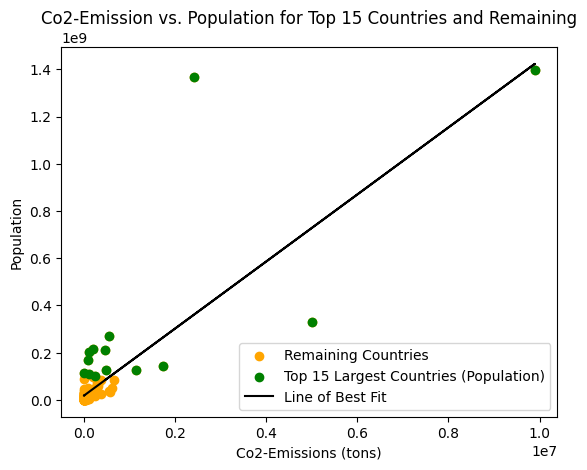

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Regression Analysis
X = country_temp_change_df['Co2-Emissions'].values.reshape(-1, 1)
Y = country_temp_change_df['Population'].values.reshape(-1, 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

linear_model = LinearRegression().fit(X_train, Y_train)

population_mask = Y_train > np.sort(Y_train, axis=0)[len(Y_train) - 15]#[int(2 * (len(Y_train) / 3))]# > country_temp_change_df['Population'].median()
plt.scatter(X_train, Y_train, color='orange', label='Remaining Countries')
plt.scatter(X_train[population_mask], Y_train[population_mask], color='green', label='Top 15 Largest Countries (Population)')
plt.plot(X_train, linear_model.predict(X_train), color='black', label='Line of Best Fit')
plt.title("Regression for Train Data")
plt.xlabel("Co2-Emissions (tons)")
plt.ylabel("Population")
plt.legend()
plt.show()

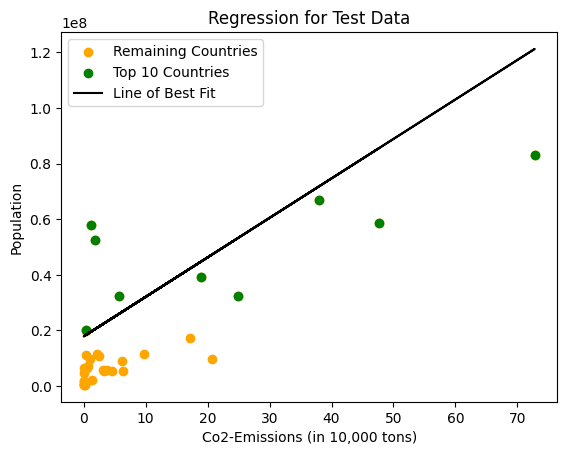

In [139]:
population_mask = Y_test > np.sort(Y_test, axis=0)[len(Y_test) - 10]
plt.scatter(X_test / 10000, Y_test, color='orange', label='Remaining Countries')
plt.scatter(X_test[population_mask] / 10000, Y_test[population_mask], color='green', label='Top 10 Countries')
plt.plot(X_test / 10000, linear_model.predict(X_test), color='black', label='Line of Best Fit')
plt.title("Regression for Test Data")
plt.xlabel("Co2-Emissions (in 10,000 tons)")
plt.ylabel("Population")
plt.legend()
plt.show()

Based on the line of best fit, we see there is a strong correlation between Co2 Emissions and Population sizes. Thus we can conclude that Countries with larger populations have a greater contribution to Co2 Emissions and thus impact the environment more.

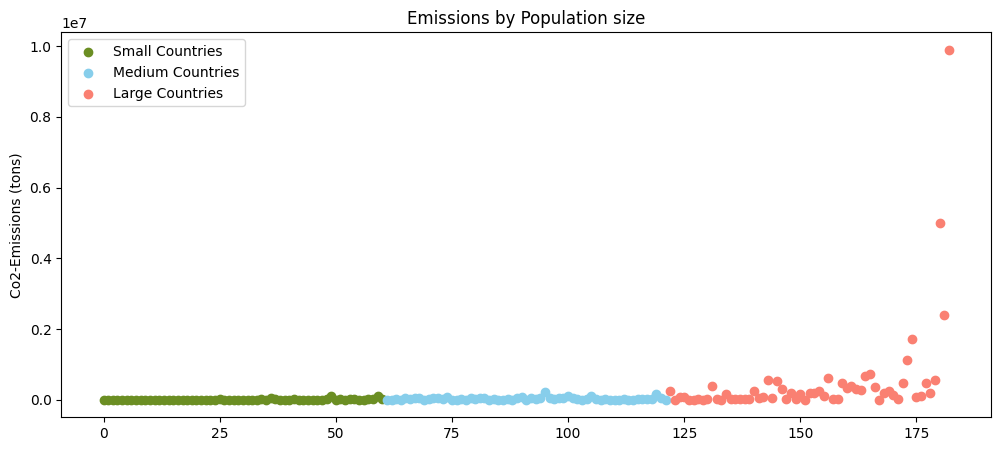

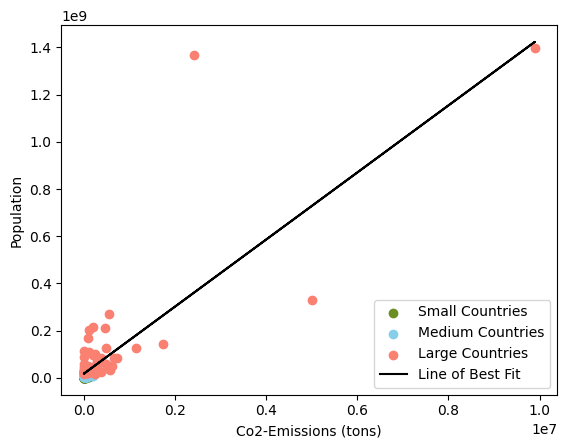

In [ ]:
# Regression Visualization

# This can maybe be improved

# Label countryes by population size (Small/Medium/Large)
sorted_populations = country_temp_change_df.sort_values(by='Population').reset_index()
num_countries = sorted_populations.shape[0]
first_third = int(num_countries / 3)
second_thrid = int(2 * (num_countries / 3))
small_ccountries = sorted_populations[:first_third]
medium_countries = sorted_populations[first_third:second_thrid]
large_countries = sorted_populations[second_thrid:]

plt.figure(figsize=(12,5))
plt.scatter(small_ccountries.index, small_ccountries['Co2-Emissions'], color='olivedrab', label='Small Countries')
plt.scatter(medium_countries.index, medium_countries['Co2-Emissions'], color='skyblue', label='Medium Countries')
plt.scatter(large_countries.index, large_countries['Co2-Emissions'], color='salmon', label='Large Countries')
plt.title("Emissions by Population size")
plt.xlabel("")
plt.ylabel("Co2-Emissions (tons)")
plt.legend()
plt.show()

plt.scatter(small_ccountries['Co2-Emissions'], small_ccountries['Population'], color='olivedrab', label='Small Countries')
plt.scatter(medium_countries['Co2-Emissions'], medium_countries['Population'], color='skyblue', label='Medium Countries')
plt.scatter(large_countries['Co2-Emissions'], large_countries['Population'], color='salmon', label='Large Countries')
plt.plot(country_temp_change_df['Co2-Emissions'], linear_model.predict(country_temp_change_df['Co2-Emissions'].values.reshape(-1, 1)), color='black', label='Line of Best Fit')
plt.xlabel("Co2-Emissions (tons)")
plt.ylabel("Population")
plt.legend()
plt.show()


In [129]:
# Clustering Analysis

In [130]:
# Clustering Visualization